# Examples of hierarchical k-means and hierarchical selection on small 2-D data

Hierarchical sampling from clusters: 100%|██████████| 300/300 [00:00<00:00, 7243.96it/s]
(1000, 2)


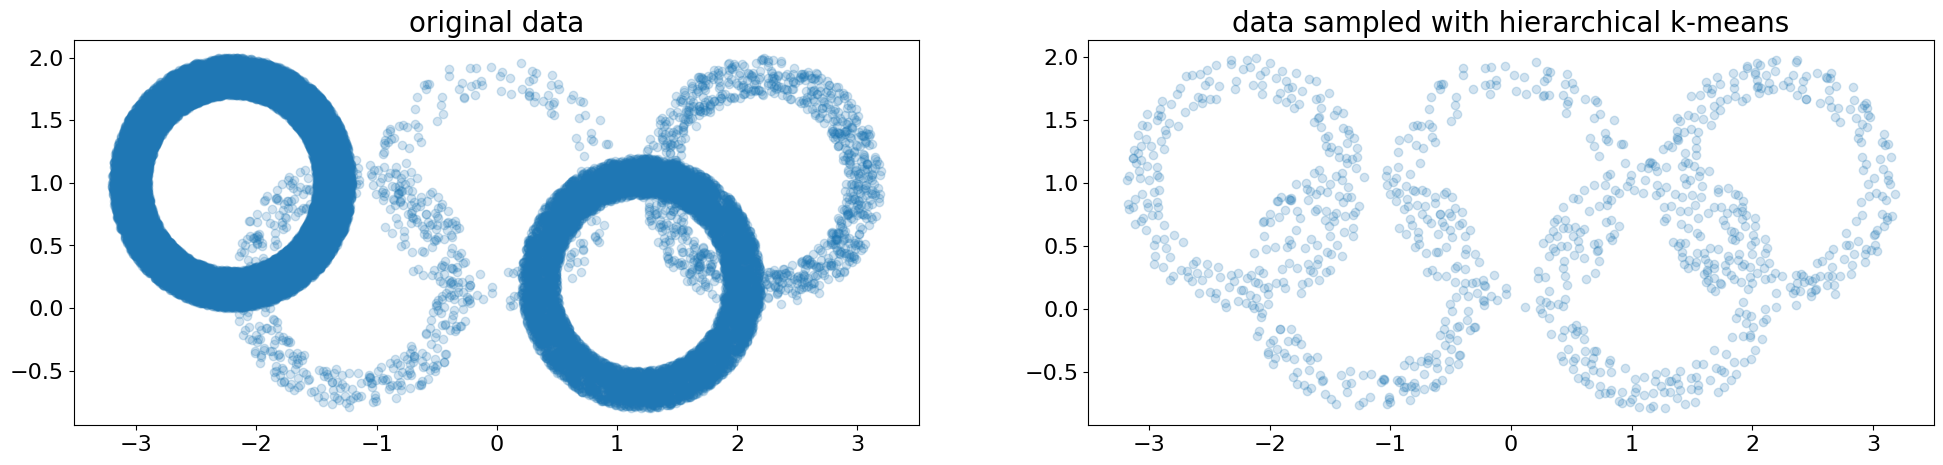

In [3]:
# eta: 1m
import sys
sys.path.insert(0, "..")

import torch
import numpy as np
from matplotlib import pyplot as plt

from src.clusters import HierarchicalCluster
from src import (
  hierarchical_kmeans_gpu as hkmg,
  hierarchical_sampling as hs
)

def make_ring(n, rmin, rmax):
    r = np.random.rand(n) * (rmax - rmin) + rmin
    alpha = np.random.rand(n) * 2 * np.pi
    return np.vstack([r * np.cos(alpha), r * np.sin(alpha)]).T

data = np.concatenate([
    make_ring(20000, 0.7, 1.0) + np.array([-2.2, 1.]),
    make_ring(200, 0.7, 1.0) + np.array([0., 1.]),
    make_ring(1000, 0.7, 1.0) + np.array([2.2, 1.]),
    make_ring(500, 0.7, 1.0) + np.array([-1.2, 0.2]),
    make_ring(8000, 0.7, 1.0) + np.array([1.2, 0.2]),
])

clusters = hkmg.hierarchical_kmeans_with_resampling(
  data=torch.tensor(data, device="cuda", dtype=torch.float32),
  n_clusters=[1000, 300],
  n_levels=2,
  sample_sizes=[15, 2],
  verbose=False,
)

cl = HierarchicalCluster.from_dict(clusters)
sampled_indices = hs.hierarchical_sampling(cl, target_size=1000)
sampled_points = data[sampled_indices]
print(sampled_points.shape)

figh, figw = 1, 2
fig, axs = plt.subplots(figh, figw, figsize=(12 * figw, 5 * figh))
axs[0].scatter(data[:, 0], data[:, 1], alpha=0.2)
axs[0].set_title("original data", fontsize=20)
axs[0].tick_params(labelsize=16)
axs[1].scatter(sampled_points[:, 0], sampled_points[:, 1], alpha=0.2)
axs[1].set_title("data sampled with hierarchical k-means", fontsize=20)
axs[1].tick_params(labelsize=16)
plt.show()


# 1D simulations

### Utils

In [4]:
%load_ext autoreload
%autoreload 2
    
import sys
sys.path.insert(0, "..")
from tqdm import tqdm

import numpy as np
from matplotlib import pyplot as plt
from matplotlib.ticker import MultipleLocator, AutoMinorLocator
from scipy.signal import savgol_filter
import torch

from generalized_kmeans_1d import generalized_kmeans_1d
from src.hierarchical_kmeans_gpu import hierarchical_kmeans_with_resampling, hierarchical_kmeans


def generate_and_visualize_1d_data():
    # Genrate data
    locs = [2.0, 5.0, 9.0]
    scales = [1.0, 0.8, 2.0]
    sizes = [60000,30000,40000]
    points = []
    for _l, _sc, _si in zip(locs, scales, sizes):
        _p = np.random.normal(loc=_l, scale = _sc, size=_si)
        _p = _p[np.logical_and(_p>=0, _p<=12)]
        points.append(_p)

    locs = [20]
    scales = [1.0]
    sizes = [90000]
    for _l, _sc, _si in zip(locs, scales, sizes):
        _p = np.random.normal(loc=_l, scale = _sc, size=_si)
        _p = _p[np.logical_and(_p>=17, _p<=23)]
        points.append(_p)

    locs = [-10]
    scales = [2.0]
    sizes = [30000]
    for _l, _sc, _si in zip(locs, scales, sizes):
        _p = np.random.normal(loc=_l, scale = _sc, size=_si)
        _p = _p[np.logical_and(_p>=-14, _p<=-7)]
        points.append(_p)
        
    points = np.concatenate(points)
    print(f'Num points: {len(points)}')
    plt.hist(points.ravel(), 1000)
    plt.show()
    return points

### generate and visualize data

Num points: 243072


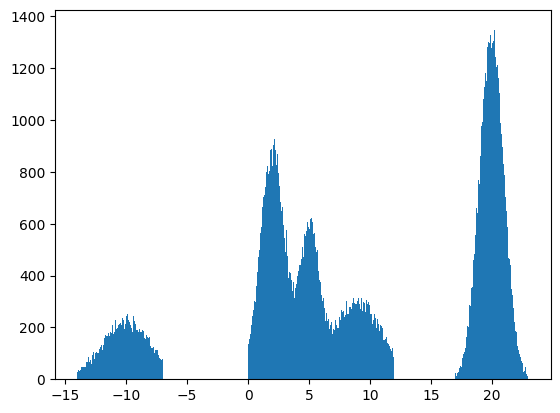

In [5]:
data_1d = generate_and_visualize_1d_data()

### run generalized k-means with different distance functions

In [6]:
# eta: 5m30s
X = torch.tensor(
    data_1d.reshape(-1, 1),
    device='cuda',
    dtype=torch.float64
)
chunk_size = int(1e8 / 5000)
powers = [2, 4]
res = {n: {} for n in powers}
for n in powers:
    print(f'Running modified kmeans with s = {2*n}')
    res[n]['centroids'], res[n]['clusters'] = generalized_kmeans_1d(X, 5000, n, chunk_size=chunk_size)
    res[n]['len_clusters'] = np.array(
        [len(el) for el in res[n]['clusters']]
    )

Running modified kmeans with s = 4


Generalized kmeans iterations: 100%|██████████| 50/50 [02:39<00:00,  3.20s/it]
Running modified kmeans with s = 8
Generalized kmeans iterations: 100%|██████████| 50/50 [02:38<00:00,  3.18s/it]


### run k-means

In [7]:
# eta: 30s
print(f'Running kmeans, for better speed, use "num_init=1"')
X = torch.tensor(data_1d.reshape(-1,1), device='cuda', dtype=torch.float64)
num_init = 1
res_1level = hierarchical_kmeans(X, [5000], 1, num_init=num_init, verbose=False)

Running kmeans, for better speed, use "num_init=1"


### generate Fig. 1(a)

<Figure size 640x480 with 0 Axes>

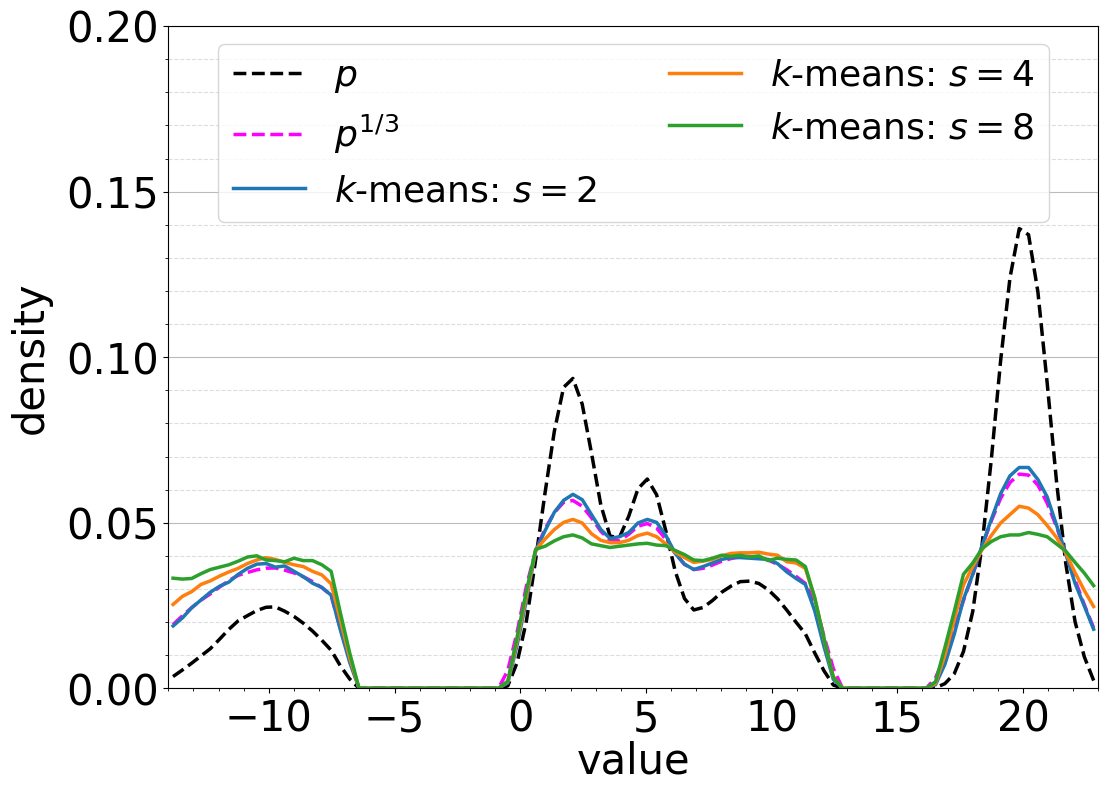

In [8]:
density={}
density_data = plt.hist(data_1d.ravel(), 100, density=True)
density_theoretical = density_data[0] ** (1 / 3) / np.sum(density_data[0] ** (1 / 3)) * 100 / 37
density_mokm_4 = plt.hist(res[2]['centroids'].cpu().ravel(), 100, density=True)
density_mokm_8 = plt.hist(res[4]['centroids'].cpu().ravel(), 100, density=True)
density_kmeans = plt.hist(res_1level[-1]['centroids'].cpu().ravel(), 100, density=True)
plt.clf()

fig, ax = plt.subplots(1, 1, figsize=(12, 8.6))
plt.rcParams['axes.axisbelow'] = True

fontsize=30
lw=2.5
ax.plot((density_data[1][1:] + density_data[1][:-1])/2, savgol_filter(density_data[0],3,1), label="$p$", linestyle='--', linewidth=lw, color="0")
ax.plot((density_data[1][1:] + density_data[1][:-1])/2, savgol_filter(density_theoretical,3,1), label="$p^{1/3}$", linestyle='--', linewidth=lw, color="magenta")
ax.plot((density_kmeans[1][1:] + density_kmeans[1][:-1])/2, savgol_filter(density_kmeans[0],3,1), label="$k$-means: $s=2$", linewidth=lw)
ax.plot((density_mokm_4[1][1:] + density_mokm_4[1][:-1])/2, savgol_filter(density_mokm_4[0],3,1), label=f"$k$-means: $s=4$", linewidth=lw)
ax.plot((density_mokm_8[1][1:] + density_mokm_8[1][:-1])/2, savgol_filter(density_mokm_8[0],3,1), label=f"$k$-means: $s=8$", linewidth=lw)

ax.set_ylim(0,0.2)
ax.set_xlim(-14, 23)
ax.legend(fontsize=fontsize-4, loc="upper center", ncol=2)

ax.xaxis.set_major_locator(MultipleLocator(5))
ax.yaxis.set_major_locator(MultipleLocator(0.05))
ax.grid(visible=True, axis="y", which='major', color='#BBBBBB', linestyle='-')
ax.grid(visible=True, axis="y", which='minor', color='#DDDDDD', linestyle='--')
ax.tick_params(axis='both', which='major', labelsize=fontsize)
ax.minorticks_on()
ax.set_xlabel("value", fontsize=fontsize, labelpad=0)
ax.set_ylabel("density", fontsize=fontsize, labelpad=10)
plt.show()


# 2D simulations

## Utils

In [9]:
import sys
sys.path.insert(0, "..")
from pathlib import Path
import pickle
import torch

import numpy as np
from scipy.spatial import Voronoi, voronoi_plot_2d

from matplotlib.pyplot import cm
from matplotlib import pyplot as plt
from sklearn.neighbors import KernelDensity
from sklearn.metrics import pairwise_distances as pwd
from matplotlib.ticker import MultipleLocator, AutoMinorLocator

from src.hierarchical_kmeans_gpu import hierarchical_kmeans_with_resampling, hierarchical_kmeans


def draw_voronoi(
    clusterings,
    clustering_names,
    legends = None,
    fontsize = 20,
    ylim = (-3, 3),
    xlim = (-3, 3),
    line_width=0.4,
    point_size=1,
    show_title=True,
    basic_fig_size = (6, 5),
    wspace=0.1,
    hspace=0.1,
):
    if legends is None:
        legends = clustering_names
    figh, figw = 1, len(clustering_names)
    fig, ax = plt.subplots(figh, figw, figsize=(basic_fig_size[0] * figw, basic_fig_size[1]))
    axs = ax.ravel()
    for i, _name in enumerate(clustering_names):
        if _name == "data":
            axs[0].scatter(clusterings[_name][:, 0], clusterings[_name][:, 1], alpha=0.2)
        else:
            vor = Voronoi(clusterings[_name][-1]['centroids'].cpu().numpy())
            voronoi_plot_2d(vor, ax=axs[i], show_vertices=False, point_size=point_size, line_width=line_width, line_alpha=0.8)
        if show_title:
            axs[i].set_title(legends[i], fontsize=int(fontsize * 0.8), pad=20)
        axs[i].set_ylim(ylim[0], ylim[1])
        axs[i].set_xlim(xlim[0], xlim[1])
        axs[i].axis('off')
    plt.subplots_adjust(wspace=wspace, hspace=hspace)
    plt.show()
    return fig

def compute_KL_divergence(kde, L, s):
    X = np.arange(-L, L, s)
    Y = np.arange(-L, L, s)
    X, Y = np.meshgrid(X, Y)
    XY = np.vstack([X.ravel(), Y.ravel()]).T
    d_u = 1/(4*L**2)
    
    d = np.exp(kde.score_samples(XY))
    d_norm = d * 1/(s**2 * d.sum())
    KL = -(d_norm * np.log(d_u/d_norm)).sum() * s**2
    return KL
    
def visualize_kde(
    clusterings,
    clustering_names,
    legends = None,
    fontsize=20,
    bandwidth=0.5,
    L=4,
    s=0.02,
    z_high=None,
    show_title=True,
    cmap_max=None,
    basic_fig_size = (6, 5),
    compute_kl = True,
    wspace=0.1,
    hspace=0.1,
):
    if z_high is None:
        z_high = [0.05] * len(clustering_names)
    if cmap_max is None:
        cmap_max = z_high
    if legends is None:
        legends = clustering_names
    kdes = {}
    for _name in clustering_names:
        kdes[_name] = KernelDensity(bandwidth=bandwidth).fit(
            clusterings[_name][-1]["centroids"].cpu().numpy()
        )
    
    fig, ax = plt.subplots(
        1, len(clustering_names),
        figsize=(basic_fig_size[0] * len(clustering_names), basic_fig_size[1]),
        subplot_kw={"projection": "3d"},
    )
    axs = ax.ravel()
    for i, _name in enumerate(clustering_names):
        X = np.arange(-L, L, 0.05)
        Y = np.arange(-L, L, 0.05)
        X, Y = np.meshgrid(X, Y)
        XY = np.vstack([X.ravel(), Y.ravel()]).T
        Z = np.exp(kdes[_name].score_samples(XY)).reshape(X.shape)
        
        _ = axs[i].plot_surface(
            X, Y, Z, cmap=cm.coolwarm, linewidth=0, antialiased=False, vmin=0, vmax=cmap_max[i],
        )
        
        axs[i].set_zlim(-0.01, z_high[i])
        axs[i].zaxis.set_major_formatter('{x:.02f}')
        if show_title:
            axs[i].set_title(legends[i], fontsize=fontsize * 8 // 10, pad=20)

        axs[i].tick_params(axis='x', which='major', labelsize=fontsize*5//10)
        axs[i].tick_params(axis='y', which='major', labelsize=fontsize*5//10)
        axs[i].tick_params(axis='z', which='major', labelsize=fontsize*5//10)
    
    plt.subplots_adjust(wspace=wspace, hspace=hspace)
    plt.show()
    
    kl_dist = None
    if compute_kl:
        kl_dist = {}
        for _name in clustering_names:
            kl = compute_KL_divergence(kdes[_name], L, s)
            kl_dist[_name] = kl
            print(f"Name: {_name}, KL divergence: {kl}")
    return fig, kl_dist
    

## generate data

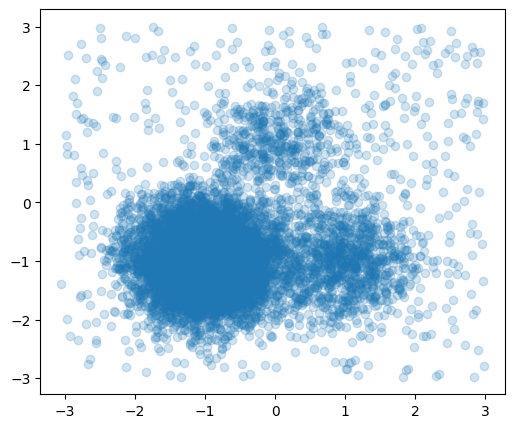

In [10]:
data = np.concatenate([
    np.random.randn(7000, 2)/2 + [-1, -1],
    np.random.randn(1000, 2)/2 + [1, -1],
    np.random.randn(500, 2)/2 + [0, 1],
    (np.random.rand(500,2) - 0.5) * 6,
])

figh, figw = 1, 1
fig, ax = plt.subplots(figh, figw, figsize=(6 * figw, 5))
ax.scatter(data[:, 0], data[:, 1], alpha=0.2)
plt.show()

## Fig. 3a: Hierarchical k-means without resampling

Running k-means


Running 2-level hierarchical k-means
Running 3-level hierarchical k-means


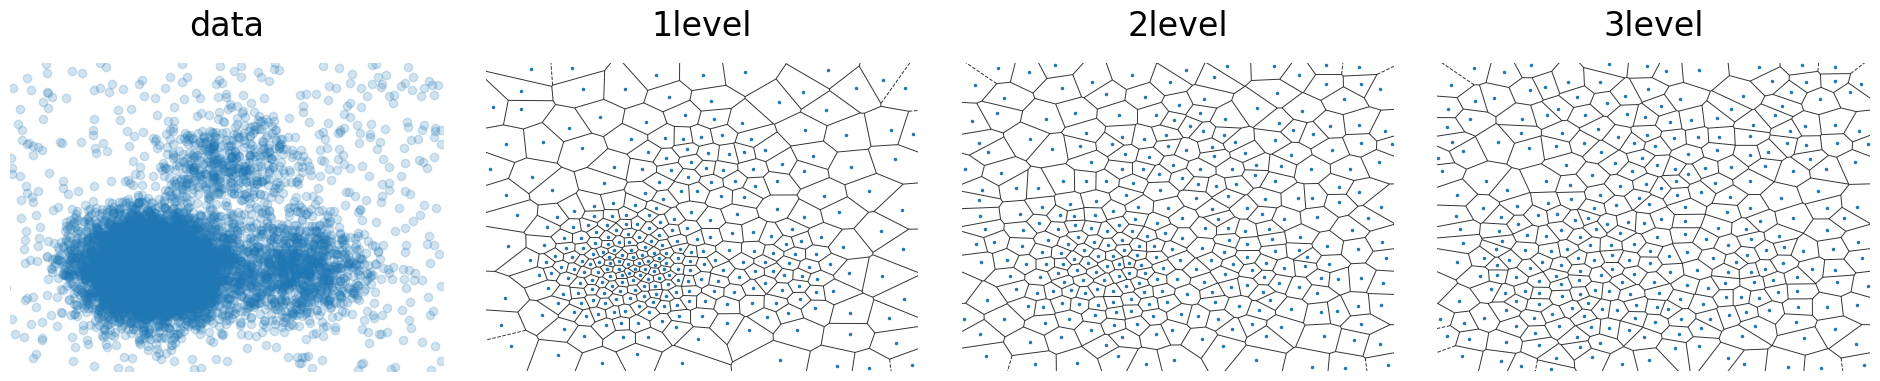

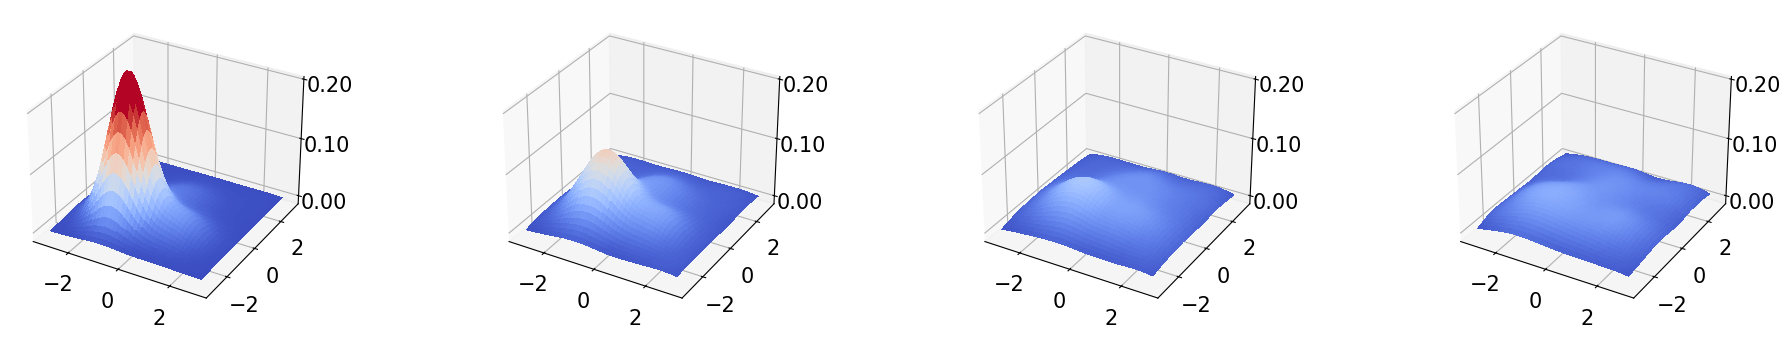

Name: data, KL divergence: 0.9422451199565022
Name: 1level, KL divergence: 0.3403619504695998
Name: 2level, KL divergence: 0.1324029674031221
Name: 3level, KL divergence: 0.08129609812283618


In [11]:
# eta: 4m30s
X = torch.tensor(data, device='cuda', dtype=torch.float32)
num_init=10
res_no_resampling = {"data": data}
print("Running k-means")
res_no_resampling["1level"] = hierarchical_kmeans(X, [300], 1, num_init=num_init, verbose=False)
print("Running 2-level hierarchical k-means")
res_no_resampling["2level"] = hierarchical_kmeans(X, [1500, 300], 2, num_init=num_init, verbose=False)
print("Running 3-level hierarchical k-means")
res_no_resampling["3level"] = hierarchical_kmeans(X, [3000, 1000, 300], 3, num_init=num_init, verbose=False)

clustering_names = ["data", "1level", "2level", "3level"]
fig = draw_voronoi(
    res_no_resampling,
    clustering_names,
    xlim=(-3, 3),
    ylim=(-3, 3),
    point_size=3,
    line_width=0.7,
    fontsize=30,
    basic_fig_size = (6,4),
)

res_no_resampling["data"] = [{"centroids": torch.tensor(data),}]
fig, kl_dist_1 = visualize_kde(
    res_no_resampling,
    clustering_names,
    legends = clustering_names,
    z_high=[0.2, 0.2, 0.2, 0.2],
    fontsize=30,
    show_title=False,
    L=3,
    basic_fig_size = (6,4),
)

## hierarchical k-means with resampling

In [12]:
# eta: 3m
X = torch.tensor(data, device='cuda', dtype=torch.float32)
num_init=1
res_closest = {"data": data}
print("Running 3-level hierarchical k-means with resampling")
res_closest["3level"] = hierarchical_kmeans_with_resampling(X, [3000, 1000, 300], 3, [2, 2, 2], num_init=num_init, verbose=False)

Running 3-level hierarchical k-means with resampling
Hierarchical k-means resampling steps: 100%|██████████| 10/10 [00:11<00:00,  1.11s/it]


## DBSCAN and Agglomerative clustering

In [13]:
from sklearn.cluster import DBSCAN, AgglomerativeClustering
from sklearn.metrics import pairwise_distances


#-------------------------------------------------------------
# DBSCAN

min_points = 5

# Plot distance to find \epsilon
pw_distance = pairwise_distances(data)
pw_distance = np.sort(pw_distance, axis=1)
nn_dist = pw_distance[:, min_points]
sorted_nn_dist = np.sort(nn_dist)[::-1]

# Visualize sorted_nn_dist to find the elbow
# the elbow is sorted_nn_dist[1000] here
# plt.plot(range(len(sorted_nn_dist)), sorted_nn_dist)
# plt.show()

# Run DBSCAN
db = DBSCAN(eps = sorted_nn_dist[1000], min_samples=min_points)
db.fit(data)
db_clusters = [
    np.where(db.labels_ == i)[0] for i in range(db.labels_.max() + 1)
]
db_centroids = np.array([
    data[db_clusters[i]].mean(axis=0) for i in range(len(db_clusters))
])


#-------------------------------------------------------------
# Agglomerative

ac = AgglomerativeClustering(n_clusters=300)
ac.fit(data)

ac_clusters = [
    np.where(ac.labels_ == i)[0] for i in range(ac.labels_.max() + 1)
] 
ac_centroids = np.array([
    data[ac_clusters[i]].mean(axis=0) for i in range(len(ac_clusters))
])

## Fig. 3b: Visualize Voronoi diagrams and KDEs of clusters given by hierarchical k-means with resampling, DBSCAN and Agglomerative

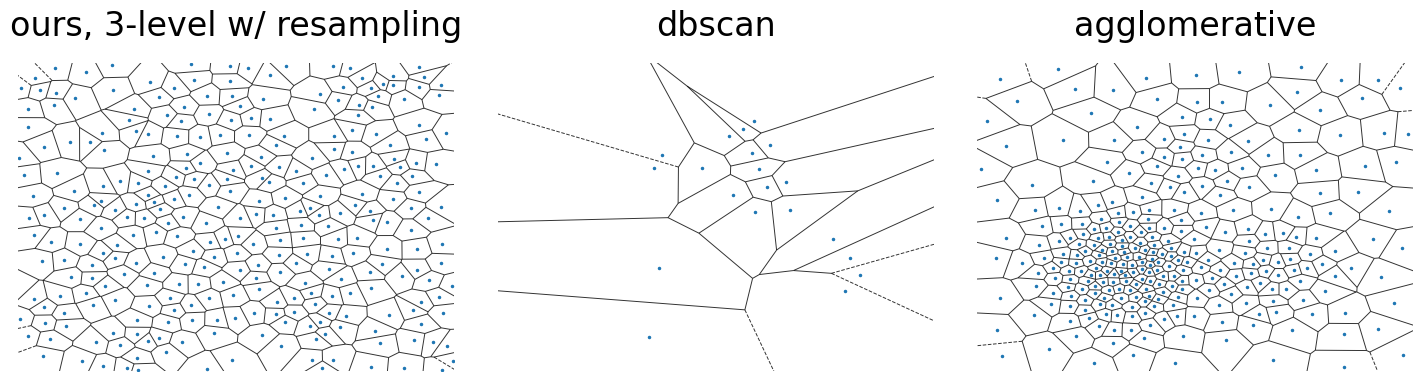

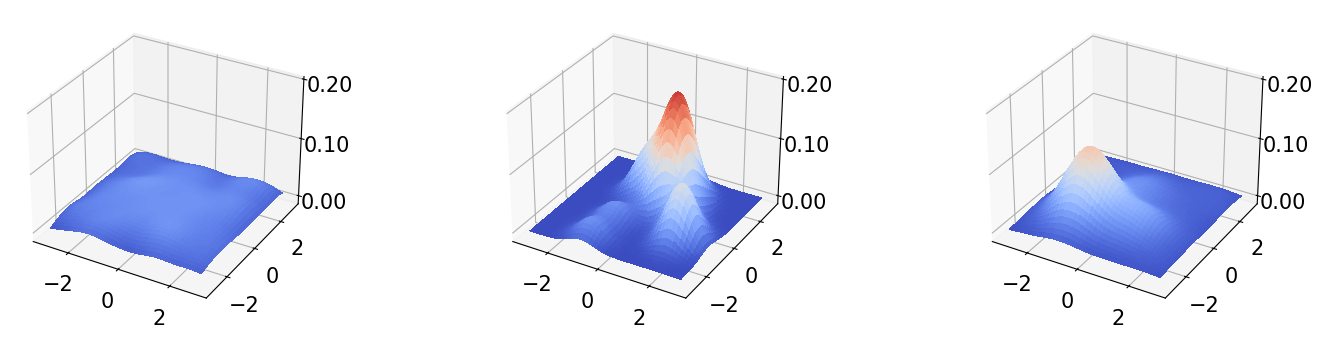

Name: Hierarchical k-means, KL divergence: 0.04177159182977974
Name: DBSCAN, KL divergence: 0.8533785604046389
Name: Agglomerative, KL divergence: 0.374086872890304
Name: Agglomerative, KL divergence: 0.374086872890304


In [14]:
vis_data = {
    "data": torch.tensor(data),
    "DBSCAN": [{"centroids": torch.tensor(db_centroids)}],
    "Agglomerative": [{"centroids": torch.tensor(ac_centroids)}],
    "Hierarchical k-means": res_closest["3level"],
    # "OPTICS": [{"centroids": torch.tensor(ot_centroids)}],
}
fig = draw_voronoi(
    vis_data,
    # ["data", "DBSCAN", "Agglomerative", "Hierarchical k-means"],
    ["Hierarchical k-means", "DBSCAN", "Agglomerative"],
    legends = ["ours, 3-level w/ resampling", "dbscan", "agglomerative"],
    xlim=(-3, 3),
    ylim=(-3, 3),
    line_width=0.7,
    fontsize=30,
    point_size=3,
    basic_fig_size = (6,4),
)
vis_data["data"] = [{"centroids": torch.tensor(data),}]
fig, kl_dist_2 = visualize_kde(
    vis_data,
    ["Hierarchical k-means", "DBSCAN", "Agglomerative"],
    legends = ["ours, 3-level w/ resampling", "dbscan", "agglomerative"],
    z_high=[0.2, 0.2, 0.2],
    fontsize=30,
    show_title=False,
    L=3,
    basic_fig_size = (6,4),
)

## Compute KL divergence between KDEs estimated on randomly sampled points and the uniform distribution on $\Omega$

In [15]:
kls = []
for _ in range(10):
    X = np.random.uniform(-3, 3, 300)
    Y = np.random.uniform(-3, 3, 300)
    XY = np.vstack([X.ravel(), Y.ravel()]).T
    kde = KernelDensity(bandwidth=0.5).fit(XY)
    kl = compute_KL_divergence(kde, 3, 0.02)
    print(f"KL divergence: {kl}")
    kls.append(kl)
print(np.mean(kls), np.std(kls))


KL divergence: 0.05194335434616153
KL divergence: 0.03662695740167336
KL divergence: 0.03618988944556734
KL divergence: 0.03627341671748882
KL divergence: 0.03135823267593617
KL divergence: 0.04457902895679862
KL divergence: 0.041379957094719554
KL divergence: 0.033544510390276325
KL divergence: 0.03535871316171948
KL divergence: 0.05389910483854848
0.040115316502888965 0.00732287137010708


## Fig 3c

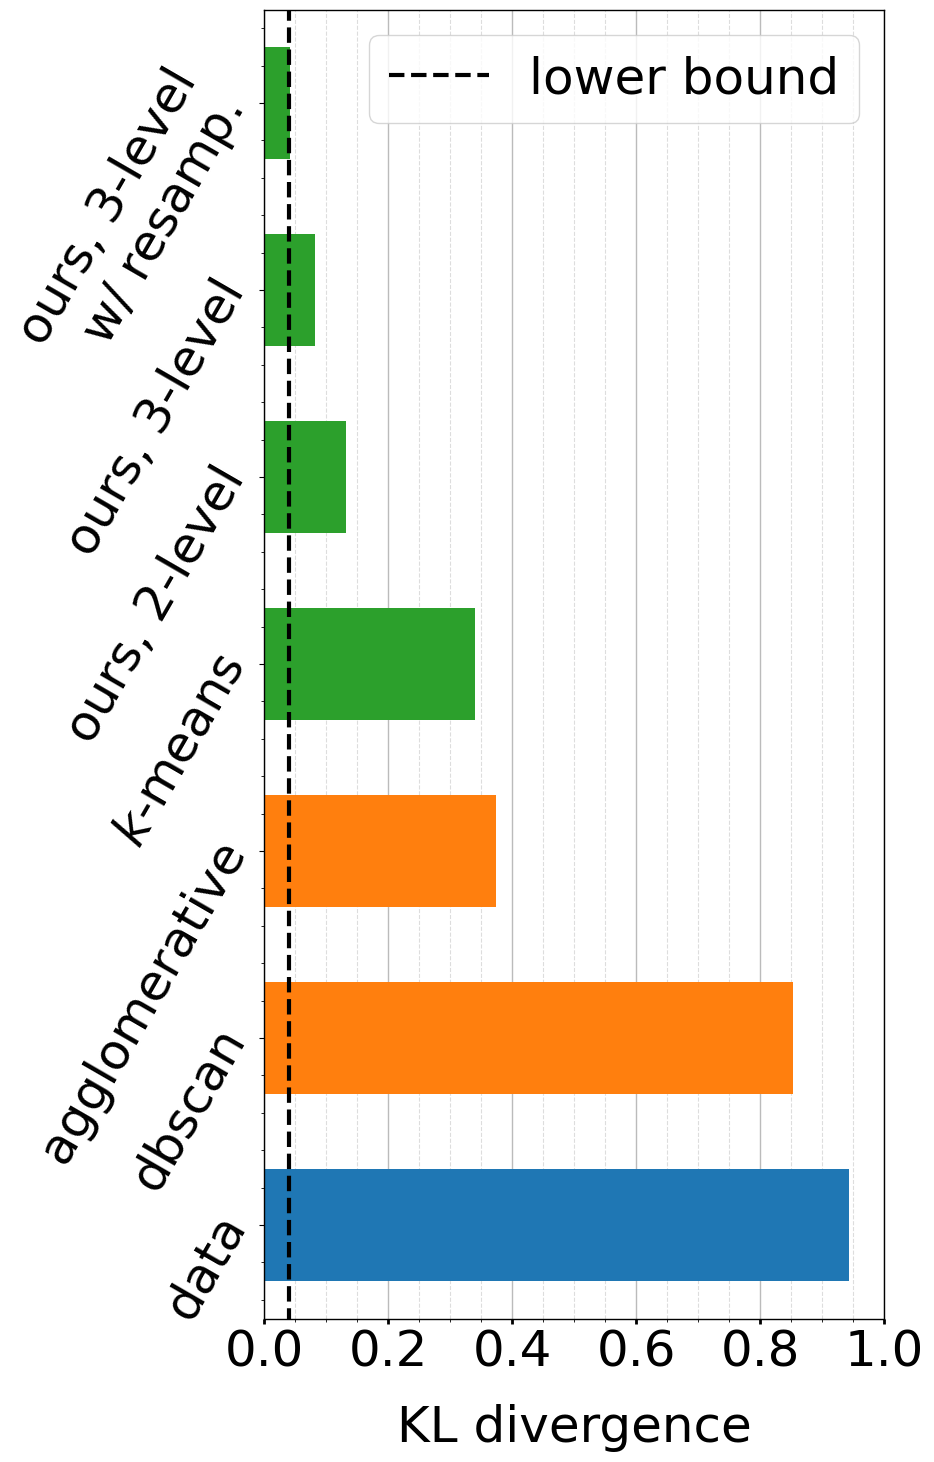

In [16]:
from matplotlib.ticker import MultipleLocator, AutoMinorLocator

marker_size = 10
KL_data = {"data" : kl_dist_1["data"]}
KL_kmeans = {
    "$k$-means": kl_dist_1["1level"],
    "ours, 2-level": kl_dist_1["2level"],
    "ours, 3-level": kl_dist_1["3level"],
    "ours, 3-level\nw/ resamp.": kl_dist_2["Hierarchical k-means"],
}
KL_others = {
    "dbscan": kl_dist_2["DBSCAN"],
    "agglomerative": kl_dist_2["Agglomerative"],
}
fig, ax = plt.subplots(1, 1, figsize=(8, 17))
plt.rcParams['axes.axisbelow'] = True

fontsize=36

width = 0.6
ax.barh(list(KL_data.keys()), list(KL_data.values()), height=width)
ax.barh(list(KL_others.keys()), list(KL_others.values()), height=width, color="#ff7f0e")
ax.barh(list(KL_kmeans.keys()), list(KL_kmeans.values()), height=width, color="#2ca02c")

ax.plot([np.mean(kls)]*12, range(-1, 11), linestyle="--", linewidth=3, label="lower bound", color="black")
ax.set_ylim(-0.5,6.5)
ax.set_xlim(0,1)
ax.legend(fontsize=fontsize)

ax.xaxis.set_major_locator(MultipleLocator(0.2))
ax.xaxis.set_minor_locator(MultipleLocator(0.05))
ax.grid(visible=True, axis="x", which='major', color='#BBBBBB', linestyle='-')
ax.grid(visible=True, axis="x", which='minor', color='#DDDDDD', linestyle='--')
ax.minorticks_on()

plt.grid(visible=True, axis="x", linewidth=1)
ax.tick_params(axis='x', which='major', labelsize=fontsize, width=2)
ax.tick_params(axis='y', which='major', labelsize=fontsize, rotation=60)
# ax.set_yticks(np.arange(7)-0.5)
# ax.invert_yaxis()
ax.set_xlabel("KL divergence", fontsize=fontsize, labelpad=20)

for _ax in [ax]:
    for axis in ['top','bottom','left','right']:
        _ax.spines[axis].set_linewidth(1)
        _ax.spines[axis].set_color((0,0,0,1))